# Router Pattern

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2


In [ ]:
# | hide
from stringdale.core import get_git_root, load_env, checkLogs, json_render

load_env()

True

In [ ]:
from typing import Union,Literal,Optional,Dict,Any
from pydantic import BaseModel,Field

from stringdale import Define,Scope,V,E,Condition
from stringdale.chat import Chat

## Sub Agents

In [ ]:
rhyming_agent = Chat(model='gpt-4o-mini',
    messages=[{'role':'system','content':"""
    Answer the following questions using rhyming words.
    """},
    {'role':'user','content':'{{question}}'},
    ],
    )


await rhyming_agent(question='what is the capital of france?')

{'role': 'assistant',
 'content': 'In Paris, the heart beats bright, a city of charm, a glorious sight.',
 'meta': {'input_tokens': 129, 'output_tokens': 24}}

In [ ]:
joke_agent = Chat(model='gpt-4o-mini',
    messages=[{'role':'system','content':"""
    Answer the following question with a joke.
    """},
    {'role':'user','content':'{{question}}'},
    ])

await joke_agent(question='what is the capital of france?')

{'role': 'assistant',
 'content': 'Why did the French chef get arrested? Because he was caught beating the eggs in Paris!',
 'meta': {'input_tokens': 127, 'output_tokens': 26}}

In [ ]:
yo_mama_chat = Chat(model='gpt-4o-mini',
    messages=[{'role':'system','content':"""
    Answer the following question with a joke about the person's mother.
    """},
    {'role':'user','content':'{{question}}'},
    ])

await yo_mama_chat(question='what is the capital of france?')

{'role': 'assistant',
 'content': 'Why did your mother go to Paris? Because she heard the Eiffel Tower was leaning towards her after all the times you forgot your mother’s birthday!',
 'meta': {'input_tokens': 131, 'output_tokens': 36}}

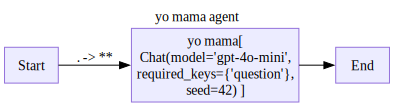

In [ ]:
with Define('yo mama agent') as YoMamaAgent:
    V('yo mama',yo_mama_chat,inputs=['Start(**)'],outputs=['End'])
YoMamaAgent.draw()

In [ ]:
yo_mama_agent = YoMamaAgent()
yo_mama_agent.run_all({
    'question':'what is the capital of france?'
    })

{'role': 'assistant',
 'content': 'Why did your mother go to Paris? Because she heard the Eiffel Tower was leaning towards her after all the times you forgot your mother’s birthday!',
 'meta': {'input_tokens': 131, 'output_tokens': 36}}

## Router Factory

In [ ]:
def RouterFactory(sub_agents:Dict[str,Any],default_choice:str):

    router = Chat(model='gpt-4o-mini',
        messages=[{'role':'system','content':"""
        Choose the best sub-agent to answer the following question from among the following options:
        {% for name,description in choice_descriptions.items() %}
        - {{name}}: {{description}}
        {% endfor %}
        """},
        {'role':'user','content':'{{question}}'},
        ],
        choice_descriptions = {name:agent['description'] for name,agent in sub_agents.items()},
        choices=list(sub_agents.keys())
    )

    with Define('Router',type='decision') as CompoundRouter:
        with Scope('flow'):
            V('choose_route',router,inputs=['Start(question=.)'])
            V('router',
                inputs=[
                    'choose_route(choice=content)',
                    'Start(question=.)'
                    ],)

        default = 'rhyme'
        for choice,agent in sub_agents.items():
            agent_func = agent['func']
            V(choice,agent_func,outputs=['End'])
            if choice == default_choice:
                E(f'router->{choice}(question=question)')
            else:
                E(f'router->{choice}(question=question)',cond=Condition(choice,'(0=choice)',name=f'choice=={choice}'))
    
    return CompoundRouter


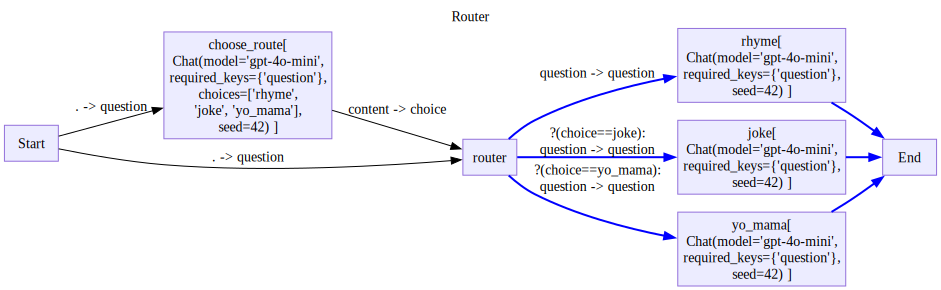

In [ ]:
sub_agents = {
    'rhyme':{
        'description':'this agent is good at rhyming',
        'func':rhyming_agent
    },
    'joke':{
        'description':'this agent is good at telling jokes',
        'func':joke_agent
    },
    'yo_mama':{
        'description':'this agent is specifically good at telling jokes about mothers',
        'func':yo_mama_chat
    }
}

Router = RouterFactory(sub_agents,'rhyme')
Router.draw()


In [ ]:
d = Router()
for trace in d.run({'question':"what is the capital of france?, I like yo mama jokes"}):
    trace.pprint(show_input=False,skip_passthrough=True)

Node choose_route:
{ 'output': { 'content': 'yo_mama',
              'meta': {'input_tokens': 208, 'output_tokens': 11},
              'role': 'assistant'}}
Node yo_mama:
{ 'output': { 'content': 'Why did your mother go to Paris? Because she heard '
                         'the Eiffel Tower was leaning towards her!',
              'meta': {'input_tokens': 141, 'output_tokens': 26},
              'role': 'assistant'}}
